In [3]:
# ===============================
# 1. Upload ZIP & Extract
# ===============================
from google.colab import files
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# ---- Upload ZIP ----
print("Upload your ZIP file containing the .npz dataset...")
uploaded = files.upload()

zip_path = list(uploaded.keys())[0]

# ---- Extract ZIP ----
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content')

print("\nExtracted files:")
!ls -lh /content


Upload your ZIP file containing the .npz dataset...


Saving Wafer_Map_Datasets.zip to Wafer_Map_Datasets.zip

Extracted files:
total 415M
drwxr-xr-x 1 root root 4.0K Nov 20 14:30 sample_data
-rw-r--r-- 1 root root 394M Nov 30 07:02 Wafer_Map_Datasets.npz
-rw-r--r-- 1 root root  22M Nov 30 07:02 Wafer_Map_Datasets.zip


In [16]:
# ===============================
# 2. Load NPZ dataset
# ===============================

# Automatically find the .npz file in /content
import glob
npz_files = glob.glob("/content/*.npz")

if len(npz_files) == 0:
    raise FileNotFoundError("No .npz file found in extracted ZIP!")

npz_path = npz_files[0]
print("Loading:", npz_path)

data = np.load(npz_path, allow_pickle=True)
print("Keys in the NPZ file:", data.files)

X = data["arr_0"] # Use 'arr_0' for wafer maps
y = data["arr_1"] # Use 'arr_1' for wafer labels

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Unique classes:", np.unique(y))

# ---- Normalize images ----
X = X.astype("float32") / 255.0

# Expand grayscale to (H,W,1)
if len(X.shape) == 3:
    X = np.expand_dims(X, axis=-1)

# Convert y from (num_samples, 8) multi-label to (num_samples,) single-label binary (0=no defects, 1=any defect)
y_single_label = (np.sum(y, axis=1) > 0).astype(int)

num_classes = len(np.unique(y_single_label))
y_cat = to_categorical(y_single_label, num_classes)

# ---- Train/test split ----
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_single_label
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Loading: /content/Wafer_Map_Datasets.npz
Keys in the NPZ file: ['arr_0', 'arr_1']
X shape: (38015, 52, 52)
y shape: (38015, 8)
Unique classes: [0 1]
Train: (30412, 52, 52, 1) Test: (7603, 52, 52, 1)


In [13]:
num_classes

2

In [14]:
# ===============================
# 3. Evaluation Helper Functions
# ===============================
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(xticks_rotation='vertical')
    plt.title(title)
    plt.show()

def per_class_accuracy(y_true, y_pred):
    true = np.argmax(y_true, axis=1)
    pred = np.argmax(y_pred, axis=1)
    classes = np.unique(true)

    print("\nPer-class accuracy:")
    for c in classes:
        idx = np.where(true == c)[0]
        acc = accuracy_score(true[idx], pred[idx])
        print(f"Class {c}: {acc:.4f}")


In [17]:
# ===============================
# Model 1. Baseline CNN
# ===============================
import tensorflow as tf
from tensorflow.keras import layers, models

baseline = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", padding="same", input_shape=X_train.shape[1:]),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])

baseline.compile(optimizer="adam",
                 loss="categorical_crossentropy",
                 metrics=["accuracy"])

baseline.summary()

history_baseline = baseline.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,384,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,403,650 (5.35 MB)

 Trainable params: 1,403,650 (5.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9637 - loss: 0.1500 - val_accuracy: 0.9730 - val_loss: 0.0879
Epoch 2/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9853 - loss: 0.0325 - val_accuracy: 1.0000 - val_loss: 0.0053
Epoch 3/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9972 - loss: 0.0120 - val_accuracy: 1.0000 - val_loss: 7.0174e-04
Epoch 4/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9999 - loss: 0.0011 - val_accuracy: 0.9911 - val_loss: 0.0255
Epoch 5/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9987 - loss: 0.0059 - val_accuracy: 0.9962 - val_loss: 0.0106
Epoch 6/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9986 - loss: 0.0079 - val_accuracy: 0.9913 - val_loss: 0.0225
Epoch 7/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9971 - loss: 0.0122 - val_accuracy: 0.9998 - val_loss: 0.0025
Epoch 8/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9988 - loss: 0.0050 - val_accurac

238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


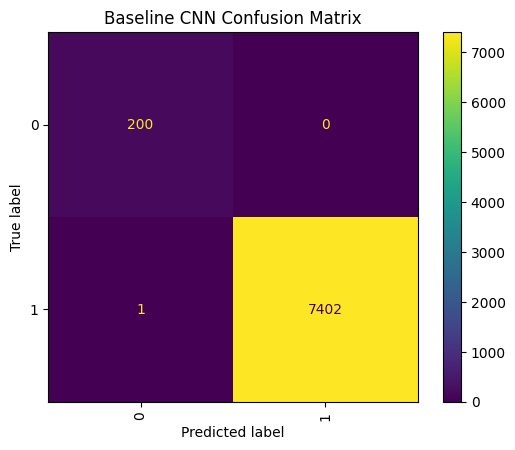

In [18]:
y_pred_baseline = baseline.predict(X_test)
plot_confusion_matrix(y_test, y_pred_baseline, "Baseline CNN Confusion Matrix")

In [24]:
per_class_accuracy(y_test, y_pred_baseline)



Per-class accuracy:
Class 0: 1.0000
Class 1: 0.9999


In [19]:
# ===============================
# Model 2. CNN with Data Augmentation
# ===============================

data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

augmented_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", padding="same", input_shape=X_train.shape[1:]),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])

augmented_model.compile(optimizer="adam",
                        loss="categorical_crossentropy",
                        metrics=["accuracy"])

history_aug = augmented_model.fit(
    data_gen.flow(X_train, y_train, batch_size=32),
    epochs=10,
    validation_data=(X_test, y_test)
)


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


951/951 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.9673 - loss: 0.1327 - val_accuracy: 0.9899 - val_loss: 0.0203
Epoch 2/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9937 - loss: 0.0219 - val_accuracy: 0.9988 - val_loss: 0.0121
Epoch 3/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9977 - loss: 0.0114 - val_accuracy: 1.0000 - val_loss: 0.0036
Epoch 4/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9953 - loss: 0.0161 - val_accuracy: 1.0000 - val_loss: 0.0031
Epoch 5/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9987 - loss: 0.0068 - val_accuracy: 0.9879 - val_loss: 0.0430
Epoch 6/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9967 - loss: 0.0103 - val_accuracy: 0.9995 - val_loss: 0.0022
Epoch 7/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.9926 - loss: 0.0205 - val_accuracy: 0.9980 - val_loss: 0.0050
Epoch 8/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9978 - loss: 0.0079 - val_accurac

238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


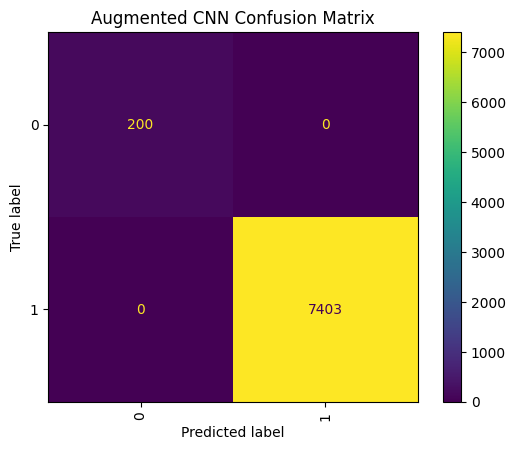

In [22]:
y_pred_aug = augmented_model.predict(X_test)
plot_confusion_matrix(y_test, y_pred_aug, "Augmented CNN Confusion Matrix")

In [23]:
# ===============================
# Model 3. Transfer Learning (MobileNetV2)
# ===============================

# Convert grayscale → RGB for MobileNet
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_test_rgb  = np.repeat(X_test, 3, axis=-1)

base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(X_train_rgb.shape[1], X_train_rgb.shape[2], 3),
    weights="imagenet"
)
base_model.trainable = False   # freeze weights

transfer_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])

transfer_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

transfer_model.summary()

history_tf = transfer_model.fit(
    X_train_rgb, y_train,
    epochs=10,
    validation_split=0.2
)


/tmp/ipython-input-1632755981.py:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 52s 50ms/step - accuracy: 0.9897 - loss: 0.0362 - val_accuracy: 0.9951 - val_loss: 0.0131
Epoch 2/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9963 - loss: 0.0094 - val_accuracy: 0.9988 - val_loss: 0.0035
Epoch 3/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9979 - loss: 0.0054 - val_accuracy: 0.9988 - val_loss: 0.0045
Epoch 4/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9984 - loss: 0.0049 - val_accuracy: 0.9993 - val_loss: 0.0033
Epoch 5/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9968 - loss: 0.0088 - val_accuracy: 0.9995 - val_loss: 0.0028
Epoch 6/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9990 - loss: 0.0029 - val_accuracy: 0.9984 - val_loss: 0.0066
Epoch 7/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9989 - loss: 0.0035 - val_accuracy: 0.9942 - val_loss: 0.0172
Epoch 8/10
761/761 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9987 - loss: 0.0030 - val_accuracy:

238/238 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step


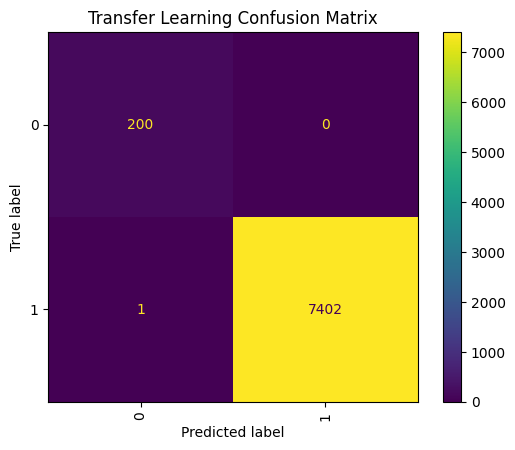

In [25]:
y_pred_tf = transfer_model.predict(X_test_rgb)
plot_confusion_matrix(y_test, y_pred_tf, "Transfer Learning Confusion Matrix")